In [ ]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
import warnings
# warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Load sub from Myspeedup: 100%|██████████| 37/37 [00:12<00:00, 100.94it/s]

00:23:32 INFO      Region of Interest:                                                                   ]8;id=526879;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=823893;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#292\292]8;;\

         INFO      -------------------                                                                   ]8;id=363001;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=44364;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#293\293]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (276.882, -11.489), model radius:     ]8;id=140889;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=472941;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py#134\134]8;;\
                  7.500 deg, display radius: 7.000 deg, threshold = 0.50                                           

         INFO                                                                                            ]8;id=16698;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=933976;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#296\296]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=84670;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=381465;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#297\297]8;;\

         INFO      --------------------                                                                  ]8;id=846430;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=154998;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#298\298]8;;\

         INFO      Width x height 90 x 90 px                                                             ]8;id=879911;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=873333;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#300\300]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=8509;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=713075;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#305\305]8;;\

         INFO                                                                                            ]8;id=382503;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=674012;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#308\308]8;;\

         INFO      Response:                                                                             ]8;id=880764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=601605;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#309\309]8;;\

         INFO      ---------                                                                             ]8;id=387560;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=699741;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#310\310]8;;\

         INFO      Response file:                                                                   ]8;id=278722;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=48357;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#340\340]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/DR_ihep_MK2_newoldDRpsf.ro                
                  ot                                                                                               

         INFO      Number of dec bins: 110                                                          ]8;id=778073;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=389923;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#341\341]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 6                                 ]8;id=288844;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=993061;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#344\344]8;;\

         INFO                                                                                            ]8;id=507442;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=336833;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#314\314]8;;\

         INFO      Map Tree:                                                                             ]8;id=465639;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=710127;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#315\315]8;;\

         INFO      ----------                                                                            ]8;id=923830;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=222887;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#316\316]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,1.912300e+06,1.890370e+06,1.011601,30460,99.86283
1,1,1024,RING,1.068157e+06,1.046597e+06,1.020600,30460,99.86283
2,2,1024,RING,1.897779e+05,1.829351e+05,1.037405,30460,99.86283
3,3,1024,RING,7.547907e+04,7.138014e+04,1.057424,30460,99.86283
4,4,1024,RING,1.752258e+04,1.629416e+04,1.075390,30460,99.86283
5,5,1024,RING,5.342905e+03,4.608799e+03,1.159284,30460,99.86283


         INFO      This Map Tree contains 795.961 transits in the first bin                         ]8;id=760037;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=647085;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#149\149]8;;\

         INFO      Total data size: 2.92 Mb                                                         ]8;id=961906;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=35139;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#151\151]8;;\

         INFO                                                                                            ]8;id=427720;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=966376;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#320\320]8;;\

         INFO      Active energy/nHit planes (6):                                                        ]8;id=493366;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=557422;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#322\322]8;;\

         INFO      -------------------------------                                                       ]8;id=165936;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=622146;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#323\323]8;;\

         INFO      ['0', '1', '2', '3', '4', '5']                                                        ]8;id=21287;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=718363;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#324\324]8;;\

00:23:33 INFO      Set WCDA tansit from: 795.9613310185185 to 796.2928263888889                         ]8;id=53328;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py\Mymap.py]8;;\:]8;id=890205;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py#41\41]8;;\

00:23:34 INFO      J1813M1245 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=99542;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=22303;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=449550;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=787466;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=2.44e-13 kb=(2.44e-15, 1.12e-12) index=-2.61 indexb=(-3.41,-1.81)                             

         INFO      Mor: fitrange=1.68                                                                  ]8;id=889133;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=31049;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#358\358]8;;\

         INFO      J1814M1719u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=876776;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=893036;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=689348;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=815309;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=2.65e-12 kb=(2.65e-14, 7.57e-12) index=-2.83 indexb=(-3.43,-2.23)                             

         INFO      Mor:                                                                                ]8;id=956898;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=193363;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.71 sb=(0.15,1.27) fitrange=2.16                                                         

00:23:35 INFO      J1825M1418 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=319681;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=923950;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=681749;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=677477;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=3.92e-12 kb=(3.92e-14, 8.52e-12) index=-2.98 indexb=(-3.48,-2.48)                             

         INFO      Mor:                                                                                ]8;id=734403;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=897261;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.81 sb=(0.41,1.21) fitrange=1.52                                                         

         INFO      J1825M1256u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=303185;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=254595;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=767892;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=567266;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=8.27e-13 kb=(8.27e-15, 1.91e-12) index=-2.61 indexb=(-2.91,-2.31)                             

         INFO      Mor:                                                                                ]8;id=246906;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=922382;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.24 sb=(0.00,0.48) fitrange=0.64                                                         

         INFO      J1825M1337u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=754364;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=372614;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=121013;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=259259;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.04e-12 kb=(1.04e-14, 2.16e-12) index=-2.55 indexb=(-2.85,-2.25)                             

         INFO      Mor:                                                                                ]8;id=286851;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=783672;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.17 sb=(0.01,0.33) fitrange=0.40                                                         

         INFO      J1831M1007u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=197204;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=982748;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=427198;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=205249;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.78e-12 kb=(1.78e-14, 3.90e-12) index=-2.71 indexb=(-3.11,-2.31)                             

         INFO      Mor:                                                                                ]8;id=415951;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=740572;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.78 sb=(0.46,1.10) fitrange=1.28                                                         

         INFO      J1834M0831 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=362013;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=582958;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=528430;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=758800;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=5.99e-13 kb=(5.99e-15, 2.78e-12) index=-3.08 indexb=(-4.00,-1.78)                             

         INFO      Mor:                                                                                ]8;id=538934;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=722489;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.40 sb=(0.00,0.96) fitrange=1.76                                                         

         INFO      J1837M0654u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=572630;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=795432;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=159315;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=365340;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.55e-12 kb=(1.55e-14, 2.63e-12) index=-2.92 indexb=(-3.22,-2.62)                             

         INFO      Mor:                                                                                ]8;id=871973;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=791018;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.34 sb=(0.26,0.42) fitrange=0.48                                                         

         INFO      J1839M0548u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=903773;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=56443;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=887279;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=258058;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=4.62e-13 kb=(4.62e-15, 1.04e-12) index=-2.65 indexb=(-3.05,-2.25)                             

         INFO      Mor:                                                                                ]8;id=371289;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=84163;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.22 sb=(0.06,0.38) fitrange=0.56                                                         

         INFO      J1841M0519 in model_radius: 7.5 sf:True pf:True kf:False indexf:False               ]8;id=221463;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=545621;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=884912;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=564437;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.52e-12 kb=(1.52e-14, 3.20e-12) index=-2.88 indexb=(-3.28,-2.48)                             

         INFO      Mor:                                                                                ]8;id=789957;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=90658;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.60 sb=(0.36,0.84) fitrange=0.72                                                         

         INFO      Set diffuse range: [11.999999999999986, 27.999999999999986] [-8, 8]                ]8;id=757579;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=555909;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1180\1180]8;;\

         INFO      ra dec coner:                                                                      ]8;id=257561;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=713420;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1181\1181]8;;\

         INFO      (280.5404381007983, -22.229791117803096)                                           ]8;id=807872;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=450706;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1182\1182]8;;\

         INFO      (287.78602111376296, -8.003302048511834)                                           ]8;id=265770;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=764461;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1183\1183]8;;\

         INFO      (273.4961143178938, -0.7052606046727239)                                           ]8;id=745249;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=890718;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1184\1184]8;;\

         INFO      (265.7232758945056, -14.5604187532161)                                             ]8;id=284036;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=412487;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1185\1185]8;;\

         INFO      total sr: 0.07772890321151499                                                      ]8;id=28855;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=7553;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1224\1224]8;;\
                  ratio: 0.028307125215400412                                                                      

         INFO      integration: 1.1768633012936065e-05                                                ]8;id=991568;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=904444;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1225\1225]8;;\
                  ratio: 0.09287284002886675                                                                       

         INFO      set K to: 1.6651714605419028e-12                                                   ]8;id=319928;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=312609;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1226\1226]8;;\

         INFO      diffuse file path: ../../data/Diffuse_WCDA_case14_dust_bkg_template.fits           ]8;id=129678;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=549867;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1253\1253]8;;\

Model summary:
==============

                   N
Point sources      1
Extended sources  10
Particle sources   0

Free parameters (39):
--------------------

                                           value min_value max_value   
J1813M1245.position.ra                    273.35    271.67    275.03  \
J1813M1245.position.dec                   -12.73    -14.41    -11.05   
J1813M1245.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1813M1245.spectrum.main.Powerlaw.index    -2.61     -3.41     -1.81   
J1814M1719u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1814M1719u.spectrum.main.Powerlaw.index   -2.83     -3.43     -2.23   
J1825M1418.Gaussian_on_sphere.lon0        276.29    274.77    277.81   
J1825M1418.Gaussian_on_sphere.lat0        -14.32    -15.84     -12.8   
J1825M1418.Gaussian_on_sphere.sigma         0.81      0.41      1.21   
J1825M1418.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1825M1418.spectrum.main.Powerlaw.index    -2.98     -3.48     -2.48   
J1825M1256u.Gaussian_on_sphere.lon0       276.55    275.91    277.19   
J1825M1256u.Gaussian_on_sphere.lat0       -13.04    -13.68     -12.4   
J1825M1256u.Gaussian_on_sphere.sigma        0.24       0.0      0.48   
J1825M1256u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1825M1256u.spectrum.main.Powerlaw.index   -2.61     -2.91     -2.31   
J1825M1337u.Gaussian_on_sphere.lon0       276.55    276.15    276.95   
J1825M1337u.Gaussian_on_sphere.lat0       -13.73    -14.13    -13.33   
J1825M1337u.Gaussian_on_sphere.sigma        0.17      0.01      0.33   
J1825M1337u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1825M1337u.spectrum.main.Powerlaw.index   -2.55     -2.85     -2.25   
J1831M1007u.Gaussian_on_sphere.lon0       277.75    276.47    279.03   
J1831M1007u.Gaussian_on_sphere.lat0       -10.12     -11.4     -8.84   
J1831M1007u.Gaussian_on_sphere.sigma        0.78      0.46       1.1   
J1831M1007u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1831M1007u.spectrum.main.Powerlaw.index   -2.71     -3.11     -2.31   
J1834M0831.Gaussian_on_sphere.lon0        278.62    276.86    280.38   
J1834M0831.Gaussian_on_sphere.lat0         -8.53    -10.29     -6.77   
J1834M0831.Gaussian_on_sphere.sigma          0.4       0.0      0.96   
J1834M0831.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1834M0831.spectrum.main.Powerlaw.index    -3.08      -4.0     -1.78   
J1837M0654u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1837M0654u.spectrum.main.Powerlaw.index   -2.92     -3.22     -2.62   
J1839M0548u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1839M0548u.spectrum.main.Powerlaw.index   -2.65     -3.05     -2.25   
J1841M0519.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1841M0519.spectrum.main.Powerlaw.index    -2.88     -3.28     -2.48   
Diffuse.spectrum.main.Powerlaw.K             0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index        -2.5      -4.5      -0.5   

                                                    unit  
J1813M1245.position.ra                               deg  
J1813M1245.position.dec                              deg  
J1813M1245.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
J1813M1245.spectrum.main.Powerlaw.index                   
J1814M1719u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J1814M1719u.spectrum.main.Powerlaw.index                  
J1825M1418.Gaussian_on_sphere.lon0                   deg  
J1825M1418.Gaussian_on_sphere.lat0                   deg  
J1825M1418.Gaussian_on_sphere.sigma                  deg  
J1825M1418.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
J1825M1418.spectrum.main.Powerlaw.index                   
J1825M1256u.Gaussian_on_sphere.lon0                  deg  
J1825M1256u.Gaussian_on_sphere.lat0                  deg  
J1825M1256u.Gaussian_on_sphere.sigma                 deg  
J1825M1256u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J1825M1256u.spe

00:23:36 INFO      Considering 7 dec bins for extended source J1814M1719u           ]8;id=805137;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=42712;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -17.330                     ]8;id=457234;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=999618;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 8 dec bins for extended source J1825M1418            ]8;id=162569;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=301466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -14.320                     ]8;id=435908;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=217771;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1825M1256u           ]8;id=521271;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=585570;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.040                     ]8;id=317760;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=285349;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 4 dec bins for extended source J1825M1337u           ]8;id=335758;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=369280;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.730                     ]8;id=334807;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=919464;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 7 dec bins for extended source J1831M1007u           ]8;id=398818;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=722406;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -10.120                     ]8;id=530406;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=340363;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1834M0831            ]8;id=164353;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=201177;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -8.530                      ]8;id=30829;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=845686;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1837M0654u           ]8;id=694628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=867383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -6.900                      ]8;id=492952;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=282052;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1839M0548u           ]8;id=621108;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=586926;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.900                      ]8;id=435234;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=719595;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1841M0519            ]8;id=531538;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=9145;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.330                      ]8;id=828373;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=45041;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 18 dec bins for extended source Diffuse              ]8;id=219313;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=68744;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -11.334                     ]8;id=415636;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=891032;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=672152;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=35410;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=577403;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=530499;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
J1813M1245.position.ra,(2.7338 +/- 0.0004) x 10^2,deg
J1813M1245.position.dec,(-1.2811 +/- 0.0034) x 10,deg
J1813M1245.spectrum.main.Powerlaw.K,(1.5 -0.5 +0.8) x 10^-22,1 / (keV s cm2)
J1813M1245.spectrum.main.Powerlaw.index,-2.54 +/- 0.19,
J1814M1719u.spectrum.main.Powerlaw.K,(1.2 -1.0 +10) x 10^-21,1 / (keV s cm2)
J1814M1719u.spectrum.main.Powerlaw.index,-2.4 +/- 0.9,
J1825M1418.Gaussian_on_sphere.lon0,(2.7639 +/- 0.0007) x 10^2,deg
J1825M1418.Gaussian_on_sphere.lat0,(-1.449 +/- 0.010) x 10,deg
J1825M1418.Gaussian_on_sphere.sigma,(5.7 +/- 0.5) x 10^-1,deg


Correlation matrix:

1.00,-0.11,0.05,-0.04,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,-0.00,-0.00,0.00,0.00,0.01,-0.00,0.01,-0.00,0.00,-0.00,0.00,0.00,-0.01,0.01
-0.11,1.00,-0.11,0.11,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.01,0.00,0.00,-0.00,-0.00,-0.01,0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.01
0.05,-0.11,1.00,-0.94,-0.00,0.01,-0.01,-0.00,0.01,0.02,0.00,-0.00,0.00,0.02,0.02,-0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.05,0.08,-0.04,-0.02,0.04,0.03,0.07,-0.01,0.07,-0.01,0.00,-0.00,0.00,0.00,-0.13,0.06
-0.04,0.11,-0.94,1.00,0.00,-0.01,0.01,0.00,-0.01,-0.01,-0.00,0.00,-0.00,-0.01,-0.01,0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.01,-0.04,-0.06,0.04,0.01,-0.03,-0.02,-0.05,0.01,-0.06,0.01,-0.00,0.00,-0.00,-0.00,0.10,-0.06
0.00,0.00,-0.00,0.00,1.00,-0.83,0.09,0.11,-0.11,-0.09,0.09,-0.01,-0.00,0.04,0.05,-0.03,-0.01,0.03,-0.03,-0.04,0.01,-0.00,-0.01,0.06,0.10,-0.05,-0.02,0.04,0.04,0.08,-0.02,0.08,-0.01,0.00,-0.00,0.00,-0.00,-0.15,0.07
0.00,-0.00,0.01,-0.01,-0.83,1.00,-0.06,-0.06,0.07,0.07,-0.06,0.00,0.00,-0.01,-0.02,0.02,0.01,-0.02,0.02,0.01,-0.00,0.00,0.01,-0.01,-0.04,0.04,0.01,-0.01,-0.01,-0.03,0.03,-0.04,0.02,-0.00,0.00,-0.00,0.00,0.07,-0.09
0.00,-0.00,-0.01,0.01,0.09,-0.06,1.00,0.18,-0.10,0.01,0.09,0.02,0.03,-0.06,-0.06,0.01,-0.27,0.15,-0.09,-0.13,0.10,0.01,0.01,-0.10,-0.13,0.04,0.03,-0.07,-0.06,-0.10,-0.01,-0.10,-0.01,-0.00,-0.00,-0.00,-0.00,0.18,0.00
-0.00,0.00,-0.00,0.00,0.11,-0.06,0.18,1.00,0.05,0.45,0.19,-0.05,-0.17,0.05,0.06,0.08,0.19,0.05,-0.52,-0.66,0.43,-0.00,-0.00,0.04,0.05,-0.02,-0.01,0.03,0.02,0.05,-0.00,0.05,-0.00,0.00,0.00,0.00,-0.00,-0.08,0.02
-0.00,0.00,0.01,-0.01,-0.11,0.07,-0.10,0.05,1.00,0.49,0.13,0.03,-0.02,-0.06,-0.10,0.12,-0.02,-0.18,-0.07,-0.06,0.02,-0.01,-0.01,0.11,0.14,-0.04,-0.04,0.08,0.07,0.12,0.01,0.12,0.02,0.00,0.00,0.00,0.00,-0.20,-0.01
-0.00,0.00,0.02,-0.01,-0.09,0.07,0.01,0.45,0.49,1.00,-0.28,-0.04,-0.13,0.05,0.05,0.08,0.14,-0.02,-0.40,-0.57,0.48,-0.01,-0.02,0.14,0.19,-0.08,-0.05,0.10,0.08,0.17,-0.02,0.17,-0.01,0.00,0.00,0.00,-0.00,-0.30,0.08
0.00,-0.00,0.00,-0.00,0.09,-0.06,0.09,0.19,0.13,-0.28,1.00,-0.02,-0.05,0.03,0.03,0.02,0.02,0.01,-0.19,-0.04,-0.16,-0.00,0.00,0.02,-0.00,0.04,-0.00,0.01,0.01,-0.01,0.04,-0.01,0.04,-0.00,-0.00,-0.00,-0.00,0.04,-0.14


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,7927.483926
total,7927.483926


Values of statistical measures:

,statistical measures
AIC,15932.984926
BIC,16327.489086


Smoothing planes:   0%|          | 0/6 [00:00<?, ?it/s]

00:31:15 INFO      Considering 7 dec bins for extended source J1814M1719u           ]8;id=637049;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=891705;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -17.330                     ]8;id=809287;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=686903;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 8 dec bins for extended source J1825M1418            ]8;id=152273;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=670793;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -14.492                     ]8;id=467372;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=305146;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1825M1256u           ]8;id=314959;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=282383;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.028                     ]8;id=105378;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=865857;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 4 dec bins for extended source J1825M1337u           ]8;id=754401;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=26026;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.710                     ]8;id=225246;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=58598;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 7 dec bins for extended source J1831M1007u           ]8;id=241182;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=733565;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -10.184                     ]8;id=650316;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=968935;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 7 dec bins for extended source J1834M0831            ]8;id=839074;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=737638;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -8.676                      ]8;id=506629;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=365356;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1837M0654u           ]8;id=981190;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=479618;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

00:31:16 INFO      Central bin is bin at Declination = -6.900                      ]8;id=222504;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=543159;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1839M0548u           ]8;id=691680;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=720164;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.900                      ]8;id=630572;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=873231;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1841M0519            ]8;id=536718;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=450588;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.330                      ]8;id=657276;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=370633;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 18 dec bins for extended source Diffuse              ]8;id=984283;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=308817;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -11.334                     ]8;id=507486;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=304594;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\


WARNING RuntimeWarning: invalid value encountered in sqrt



(274.8779296875, -10.199918091116302)


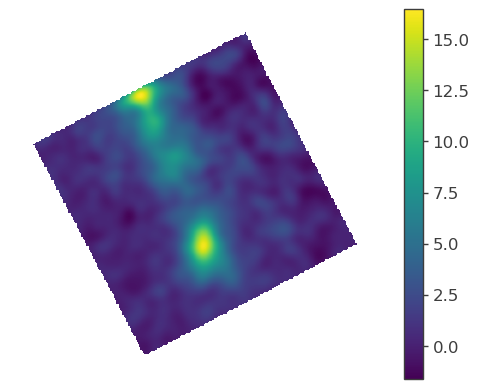

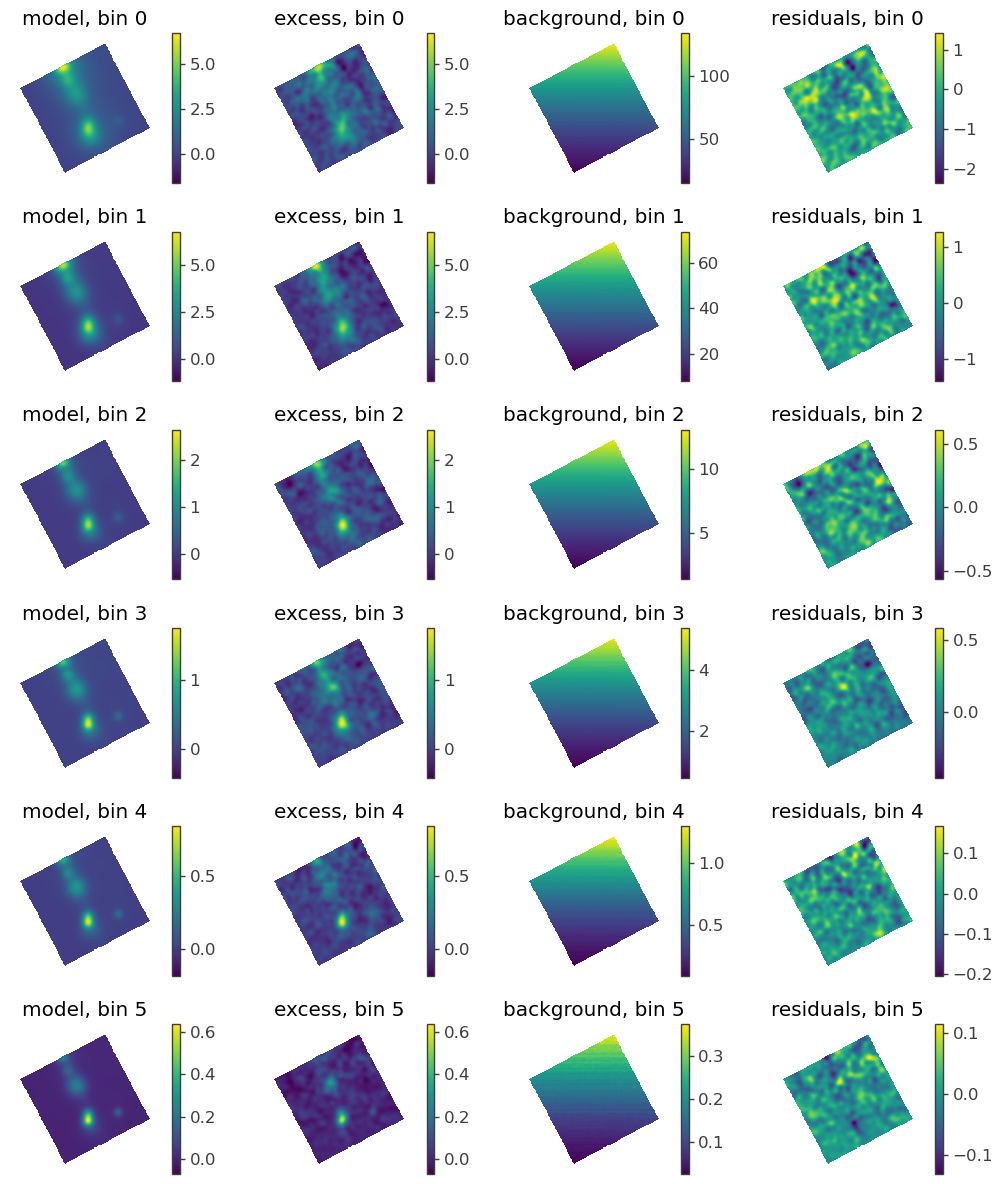

<Figure size 640x480 with 0 Axes>

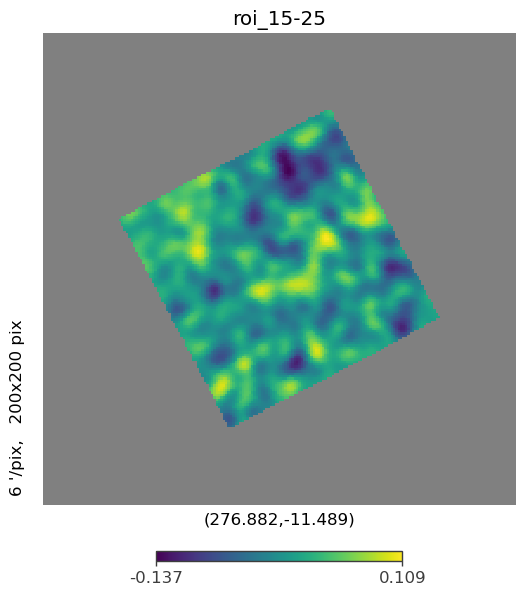

LHAASO:  1 273.36 -12.75  1LHAASO J1813-1245  0.0
LHAASO:  2 273.35 -12.73  1LHAASO J1813-1245   0.0
LHAASO:  3 273.69 -17.33 1LHAASO J1814-1719u*  0.71
LHAASO:  4 273.27 -17.89 1LHAASO J1814-1719u*   0.0
LHAASO:  5 273.72 -16.62  1LHAASO J1814-1636u  0.68
LHAASO:  6 273.72 -16.62  1KM2A J1814-1636u  0
LHAASO:  7 276.29 -14.32 1LHAASO J1825-1418  0.81
LHAASO:  8 276.25 -14.0 1LHAASO J1825-1418   0.81
LHAASO:  9 276.44 -12.94  1LHAASO J1825-1256u  0.0
LHAASO:  10 276.55 -13.04  1LHAASO J1825-1256u   0.24
LHAASO:  11 276.45 -13.63  1LHAASO J1825-1337u  0.0
LHAASO:  12 276.55 -13.73  1LHAASO J1825-1337u   0.17
LHAASO:  13 277.75 -10.12 1LHAASO J1831-1007u*  0.78
LHAASO:  14 277.81 -9.83 1LHAASO J1831-1007u*   0.26
LHAASO:  15 277.84 -10.48  1LHAASO J1831-1028  0.94
LHAASO:  16 277.84 -10.48  1KM2A J1831-1028  0
LHAASO:  17 278.62 -8.53 1LHAASO J1834-0831  0.4
LHAASO:  18 278.44 -8.38 1LHAASO J1834-0831   0.4
LHAASO:  19 279.39 -6.9 1LHAASO J1837-0654u  0.34
LHAASO:  20 279.31 -6.86 1LHAAS

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.1 +/- 0.6) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1413.572138
total,1413.572138


Values of statistical measures:

,statistical measures
AIC,2829.144299
BIC,2839.260206


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(6.9 +/- 0.5) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1439.505865
total,1439.505865


Values of statistical measures:

,statistical measures
AIC,2881.011752
BIC,2891.127659


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(8.3 +/- 0.8) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1397.061885
total,1397.061885


Values of statistical measures:

,statistical measures
AIC,2796.123791
BIC,2806.239698


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(8.6 +/- 0.8) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1323.049904
total,1323.049904


Values of statistical measures:

,statistical measures
AIC,2648.099830
BIC,2658.215737


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.6 +/- 0.9) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1170.005603
total,1170.005603


Values of statistical measures:

,statistical measures
AIC,2342.011229
BIC,2352.127136


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.9 +/- 0.9) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1153.936091
total,1153.936091


Values of statistical measures:

,statistical measures
AIC,2309.872204
BIC,2319.988111


100%|██████████| 6/6 [01:50<00:00, 18.38s/it]


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid value encountered in long_scalars


WARNING RuntimeWarning: Mean of empty slice.


WARNING RuntimeWarning: invalid 

00:34:27 INFO      Region of Interest:                                                                   ]8;id=923423;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=714409;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#292\292]8;;\

         INFO      -------------------                                                                   ]8;id=521388;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=941128;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#293\293]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (281.522, -2.609), model radius:      ]8;id=260735;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=14735;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py#134\134]8;;\
                  7.500 deg, display radius: 7.000 deg, threshold = 0.50                                           

         INFO                                                                                            ]8;id=600030;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=758749;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#296\296]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=38533;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=469264;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#297\297]8;;\

         INFO      --------------------                                                                  ]8;id=31590;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=309482;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#298\298]8;;\

         INFO      Width x height 90 x 90 px                                                             ]8;id=589642;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=387996;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#300\300]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=809325;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=98019;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#305\305]8;;\

         INFO                                                                                            ]8;id=132970;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=220780;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#308\308]8;;\

         INFO      Response:                                                                             ]8;id=351631;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=335253;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#309\309]8;;\

         INFO      ---------                                                                             ]8;id=255423;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=677201;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#310\310]8;;\

         INFO      Response file:                                                                   ]8;id=412211;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=930755;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#340\340]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/DR_ihep_MK2_newoldDRpsf.ro                
                  ot                                                                                               

         INFO      Number of dec bins: 110                                                          ]8;id=212057;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=292925;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#341\341]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 6                                 ]8;id=104559;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=269948;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#344\344]8;;\

         INFO                                                                                            ]8;id=514505;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=98167;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#314\314]8;;\

         INFO      Map Tree:                                                                             ]8;id=120076;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=351759;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#315\315]8;;\

         INFO      ----------                                                                            ]8;id=676476;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=924813;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#316\316]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,5.178574e+06,5.125754e+06,1.010305,30470,99.895615
1,1,1024,RING,2.823704e+06,2.769105e+06,1.019717,30470,99.895615
2,2,1024,RING,5.113459e+05,4.910174e+05,1.041401,30470,99.895615
3,3,1024,RING,2.168321e+05,2.038489e+05,1.063691,30470,99.895615
4,4,1024,RING,5.586728e+04,5.122473e+04,1.090631,30470,99.895615
5,5,1024,RING,1.611700e+04,1.409437e+04,1.143506,30470,99.895615


         INFO      This Map Tree contains 795.961 transits in the first bin                         ]8;id=456764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=364636;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#149\149]8;;\

         INFO      Total data size: 2.93 Mb                                                         ]8;id=696377;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=295628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#151\151]8;;\

         INFO                                                                                            ]8;id=577700;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=176263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#320\320]8;;\

         INFO      Active energy/nHit planes (6):                                                        ]8;id=496971;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=156224;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#322\322]8;;\

         INFO      -------------------------------                                                       ]8;id=917884;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=318468;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#323\323]8;;\

         INFO      ['0', '1', '2', '3', '4', '5']                                                        ]8;id=808052;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=569705;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#324\324]8;;\

00:34:28 INFO      Set WCDA tansit from: 795.9613310185185 to 796.2928263888889                         ]8;id=478255;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py\Mymap.py]8;;\:]8;id=386585;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py#41\41]8;;\

00:34:30 INFO      J1834M0831 in model_radius: 7.5 sf:True pf:True kf:False indexf:False               ]8;id=595593;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=722061;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=55113;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=130162;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=5.99e-13 kb=(5.99e-15, 2.78e-12) index=-3.08 indexb=(-4.00,-1.78)                             

         INFO      Mor:                                                                                ]8;id=719060;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=910931;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.40 sb=(0.00,0.96) fitrange=1.76                                                         

         INFO      J1837M0654u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=728814;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=12937;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=377867;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=165788;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.55e-12 kb=(1.55e-14, 2.63e-12) index=-2.92 indexb=(-3.22,-2.62)                             

         INFO      Mor:                                                                                ]8;id=389638;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=68506;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.34 sb=(0.26,0.42) fitrange=0.48                                                         

         INFO      J1839M0548u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=185473;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=55152;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=467675;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=953301;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=4.62e-13 kb=(4.62e-15, 1.04e-12) index=-2.65 indexb=(-3.05,-2.25)                             

         INFO      Mor:                                                                                ]8;id=260124;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=917892;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.22 sb=(0.06,0.38) fitrange=0.56                                                         

         INFO      J1841M0519 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=688968;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=715748;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=547860;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=755831;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.52e-12 kb=(1.52e-14, 3.20e-12) index=-2.88 indexb=(-3.28,-2.48)                             

         INFO      Mor:                                                                                ]8;id=223968;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=711667;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.60 sb=(0.36,0.84) fitrange=0.72                                                         

         INFO      J1843M0335u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=578697;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=823202;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=443769;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=492882;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=9.01e-13 kb=(9.01e-15, 1.76e-12) index=-2.58 indexb=(-2.88,-2.28)                             

         INFO      Mor:                                                                                ]8;id=357502;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=456989;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.40 sb=(0.24,0.56) fitrange=0.48                                                         

         INFO      J1848M0153u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=200399;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=4368;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=30742;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=469290;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=7.05e-13 kb=(7.05e-15, 1.51e-12) index=-2.65 indexb=(-3.05,-2.25)                             

         INFO      Mor:                                                                                ]8;id=305048;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=725408;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.51 sb=(0.27,0.75) fitrange=0.80                                                         

         INFO      J1850M0004u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=438977;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=814170;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=155429;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=856320;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=5.30e-13 kb=(5.30e-15, 1.17e-12) index=-2.49 indexb=(-2.89,-2.09)                             

         INFO      Mor:                                                                                ]8;id=876844;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=554831;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.46 sb=(0.30,0.62) fitrange=0.64                                                         

         INFO      J1852P0050u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=285883;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=527261;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=207730;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=203659;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=4.67e-13 kb=(4.67e-15, 1.87e-12) index=-2.74 indexb=(-3.34,-2.14)                             

         INFO      Mor:                                                                                ]8;id=272476;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=879870;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.64 sb=(0.08,1.20) fitrange=1.60                                                         

         INFO      J1857P0245 in model_radius: 7.5 sf:True pf:True kf:False indexf:False               ]8;id=847595;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=730097;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=736516;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=289166;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=4.04e-13 kb=(4.04e-15, 1.54e-12) index=-2.93 indexb=(-3.63,-2.23)                             

         INFO      Mor:                                                                                ]8;id=120586;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=359521;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.24 sb=(0.00,0.56) fitrange=0.88                                                         

         INFO      J1857P0203u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=905189;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=698718;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=23319;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=411840;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.68e-13 kb=(1.68e-15, 1.03e-12) index=-2.46 indexb=(-3.56,-1.36)                             

         INFO      Mor:                                                                                ]8;id=107946;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=580220;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.19 sb=(0.00,0.43) fitrange=0.88                                                         

         INFO      J1858P0330 in model_radius: 7.5 sf:True pf:True kf:False indexf:False               ]8;id=388326;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=125050;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=446065;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=635581;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=2.84e-13 kb=(2.84e-15, 1.54e-12) index=-2.63 indexb=(-3.63,-1.63)                             

         INFO      Mor:                                                                                ]8;id=546785;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=679175;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.52 sb=(0.00,1.16) fitrange=2.72                                                         

         INFO      Set diffuse range: [21.999999999999996, 38.0] [-8, 8]                              ]8;id=574517;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=330076;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1180\1180]8;;\

         INFO      ra dec coner:                                                                      ]8;id=375057;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=366401;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1181\1181]8;;\

         INFO      (285.1111448645484, -13.33226615285233)                                            ]8;id=468888;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=683104;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1182\1182]8;;\

         INFO      (292.2851875706872, 0.824806837165148)                                             ]8;id=451267;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=736272;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1183\1183]8;;\

         INFO      (277.9935514455195, 8.124031298039846)                                             ]8;id=971223;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=770576;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1184\1184]8;;\

         INFO      (270.70021251634495, -5.950912756760419)                                           ]8;id=231331;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=617866;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1185\1185]8;;\

         INFO      total sr: 0.07821470885658696                                                      ]8;id=314869;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=255527;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1224\1224]8;;\
                  ratio: 0.028484044747996665                                                                      

         INFO      integration: 1.2237276155716094e-05                                                ]8;id=810943;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=826940;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1225\1225]8;;\
                  ratio: 0.09657116417426183                                                                       

         INFO      set K to: 1.731480876909818e-12                                                    ]8;id=632521;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=195142;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1226\1226]8;;\

         INFO      diffuse file path: ../../data/Diffuse_WCDA_case14_dust_bkg_template.fits           ]8;id=667124;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=363239;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1253\1253]8;;\

Model summary:
==============

                   N
Point sources      0
Extended sources  12
Particle sources   0

Free parameters (45):
--------------------

                                           value min_value max_value   
J1834M0831.spectrum.main.Powerlaw.K          0.0       0.0       0.0  \
J1834M0831.spectrum.main.Powerlaw.index    -3.08      -4.0     -1.78   
J1837M0654u.Gaussian_on_sphere.lon0       279.39    278.91    279.87   
J1837M0654u.Gaussian_on_sphere.lat0         -6.9     -7.38     -6.42   
J1837M0654u.Gaussian_on_sphere.sigma        0.34      0.26      0.42   
J1837M0654u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1837M0654u.spectrum.main.Powerlaw.index   -2.92     -3.22     -2.62   
J1839M0548u.Gaussian_on_sphere.lon0       279.85    279.29    280.41   
J1839M0548u.Gaussian_on_sphere.lat0         -5.9     -6.46     -5.34   
J1839M0548u.Gaussian_on_sphere.sigma        0.22      0.06      0.38   
J1839M0548u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1839M0548u.spectrum.main.Powerlaw.index   -2.65     -3.05     -2.25   
J1841M0519.Gaussian_on_sphere.lon0        280.33    279.61    281.05   
J1841M0519.Gaussian_on_sphere.lat0         -5.33     -6.05     -4.61   
J1841M0519.Gaussian_on_sphere.sigma          0.6      0.36      0.84   
J1841M0519.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1841M0519.spectrum.main.Powerlaw.index    -2.88     -3.28     -2.48   
J1843M0335u.Gaussian_on_sphere.lon0       281.01    280.53    281.49   
J1843M0335u.Gaussian_on_sphere.lat0         -3.5     -3.98     -3.02   
J1843M0335u.Gaussian_on_sphere.sigma         0.4      0.24      0.56   
J1843M0335u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1843M0335u.spectrum.main.Powerlaw.index   -2.58     -2.88     -2.28   
J1848M0153u.Gaussian_on_sphere.lon0       282.06    281.26    282.86   
J1848M0153u.Gaussian_on_sphere.lat0        -1.89     -2.69     -1.09   
J1848M0153u.Gaussian_on_sphere.sigma        0.51      0.27      0.75   
J1848M0153u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1848M0153u.spectrum.main.Powerlaw.index   -2.65     -3.05     -2.25   
J1850M0004u.Gaussian_on_sphere.lon0       282.74     282.1    283.38   
J1850M0004u.Gaussian_on_sphere.lat0        -0.07     -0.71      0.57   
J1850M0004u.Gaussian_on_sphere.sigma        0.46       0.3      0.62   
J1850M0004u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1850M0004u.spectrum.main.Powerlaw.index   -2.49     -2.89     -2.09   
J1852P0050u.Gaussian_on_sphere.lon0       283.73    282.13    285.33   
J1852P0050u.Gaussian_on_sphere.lat0          1.4      -0.2       3.0   
J1852P0050u.Gaussian_on_sphere.sigma        0.64      0.08       1.2   
J1852P0050u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1852P0050u.spectrum.main.Powerlaw.index   -2.74     -3.34     -2.14   
J1857P0245.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1857P0245.spectrum.main.Powerlaw.index    -2.93     -3.63     -2.23   
J1857P0203u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1857P0203u.spectrum.main.Powerlaw.index   -2.46     -3.56     -1.36   
J1858P0330.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1858P0330.spectrum.main.Powerlaw.index    -2.63     -3.63     -1.63   
Diffuse.spectrum.main.Powerlaw.K             0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index        -2.5      -4.5      -0.5   

                                                    unit  
J1834M0831.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
J1834M0831.spectrum.main.Powerlaw.index                   
J1837M0654u.Gaussian_on_sphere.lon0                  deg  
J1837M0654u.Gaussian_on_sphere.lat0                  deg  
J1837M0654u.Gaussian_on_sphere.sigma                 deg  
J1837M0654u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J1837M0654u.spectrum.main.Powerlaw.index                  
J1839M0548u.Gaussian_on_sphere.lon0                  de

00:34:31 INFO      Considering 6 dec bins for extended source J1834M0831            ]8;id=781626;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=866463;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -8.530                      ]8;id=342721;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=706831;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1837M0654u           ]8;id=149579;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=851100;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -6.900                      ]8;id=863845;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=416474;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1839M0548u           ]8;id=90718;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=305035;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.900                      ]8;id=579679;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=151915;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1841M0519            ]8;id=197611;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=58649;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.330                      ]8;id=953656;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=734798;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1843M0335u           ]8;id=442186;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=618417;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -3.500                      ]8;id=139996;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=519837;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1848M0153u           ]8;id=990370;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=951292;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -1.890                      ]8;id=827620;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=81565;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1850M0004u           ]8;id=951457;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=790471;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -0.070                      ]8;id=626646;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=684837;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 8 dec bins for extended source J1852P0050u           ]8;id=382899;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=899167;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 1.400                       ]8;id=295127;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=922306;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1857P0245            ]8;id=340344;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=872275;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 2.750                       ]8;id=441103;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=833486;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1857P0203u           ]8;id=853272;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=748263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 1.980                       ]8;id=636651;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=703288;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 7 dec bins for extended source J1858P0330            ]8;id=890174;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=616467;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 3.700                       ]8;id=791467;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=432705;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 18 dec bins for extended source Diffuse              ]8;id=569198;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=951991;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -2.471                      ]8;id=144808;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=323078;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=592085;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=876481;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=222528;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714270;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

In [62]:
%matplotlib inline
#####   Data Initialize
# activate_warnings()

# maptree = "../../data/gcd_new.root"
# response="../../data/WCDA_DR_psf.root"

# maptree =  "../../data/hsc2healpix_20210305_20220930.root"
# response = "../../data/WCDA_DR2.root"

# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
# response = "../../data/DR_ihep_MK2.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

maptree =  "../../data/20210305-20230731_trans_fromhsc.root"
response = "../../data/DR_ihep_MK2_newoldDRpsf.root"


region_name="Diffuse_WCDA_case14"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')


nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix
pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = hp.pix2ang(nside, pixIdx)[0] # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1] # phis, same
c_icrs = SkyCoord(ra=new_lons*180/np.pi*u.degree, dec=90*u.degree-new_lats*180/np.pi*u.degree, frame='icrs')
c_l=c_icrs.galactic.l.deg
c_b=c_icrs.galactic.b.deg

resultsall = []
for i,gl in enumerate(range(20,360,10)): # #!!!!!!!!!!!!!!!!!!!365   
    c_gal = SkyCoord(l=(gl)*u.degree, b=0*u.degree, frame='galactic')
    RA_center=c_gal.icrs.ra.deg
    Dec_center=c_gal.icrs.dec.deg
    if (Dec_center<-20. or Dec_center>80.): continue
    signal=np.zeros(npix,dtype=np.float64)
    mask = ( (c_l< gl + 5) & (c_l > gl - 5) & (c_b <5.) & (c_b>-5) & (90-new_lats/np.pi*180>-20) & (90-new_lats/np.pi*180<80)) #&(new_lats<110/180*np.pi )  & (new_lats > 10/180*np.pi )
        
    signal[mask]=1
    # hp.mollview(signal,title="ROI",norm='hist')
    # hp.graticule()
    ra1,dec1=RA_center, Dec_center

    data_radius = 7
    model_radius = 7.5

    roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=signal)

    WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

    #####   Data Situation
    %matplotlib inline
    WCDA.set_active_measurements(0, 5)
    WCDA.display()
    WCDA.psf_integration_method="exact"

    my.settransWCDA(WCDA, ra1, dec1)

    Modelname=f"roi_{gl - 5}-{gl + 5}"
    if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
        os.system(f'mkdir ../res/{region_name}/{Modelname}/')
    fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
    fig.savefig(f"../res/{region_name}/{Modelname}_counts_all.png",dpi=300)

    lm = my.getcatModel(ra1, dec1, data_radius, model_radius, rtsigma=8, rtflux=20, rtindex=10, rtp=8,  detector="WCDA", roi=roi, pf=False, sf=False, kf=False, indexf=False,  mkf=False, mindexf=False, setdeltabypar=True) #indexb=(-4,-1),

    Diffuse, diffscaleratio = my.set_diffusebkg(
                ra1, dec1, 8, 8, Kf=False, indexf=False, name=region_name, ifreturnratio=True, Kb=(1e-18, 1e-10), indexb=(-4.5, -0.5), index=-2.5, setdeltabypar=True
                ) #Kn=1 , K=1e-12
    
    lm.add_source(Diffuse)

    lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
    lm.display(complete=True)

    result = my.fit(region_name, Modelname, WCDA, lm, 0, 5, mini="ROOT", donwtlimit=True) # , ifgeterror=True
    sources = my.get_sources(lm,result)
    resultsall.append([result, sources, diffscaleratio])

    resu = my.getressimple(WCDA, lm)
    new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
    new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
    print(new_source_lon_lat)

    plt.figure()
    hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
    plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
    plt.show()
    plt.savefig(f"../res/{region_name}/{Modelname}_res.png",dpi=300)

    map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
    map2 = my.maskroi(map2, roi)
    sources.pop("Diffuse")
    fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                    color="Fermi",
                    colors = my.colorall
                    )
    # try:
    Flux_WCDA0, jls0  = my.getdatapoint(WCDA, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, iffixtans=1)
    import matplotlib as mpl

    x_Max=50.
    x_Min=1
    y_Min=0.8e-13
    y_Max=2e-10
    fig,ax = plt.subplots()
    plot_spectra(
        result[0].results,
        sources_to_use=["Diffuse"], #,"ext1","ext2","ext4","ext5","ext6","ext7"|
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit="TeV/(s cm2)",
        subplot=ax,
        )

    my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA0,"Diffuse","tab:red")

    ax.set_xlim(x_Min,x_Max)
    ax.set_ylim(y_Min,y_Max)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
    ax.set_xlabel("Energy [TeV]")
    plt.legend()
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')
    # except:   pass
    #     continue

roi_15-25


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_25-35


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_35-45


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_45-55


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_55-65


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_65-75


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_75-85


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_85-95
roi_95-105
roi_105-115
roi_115-125
roi_125-135
roi_135-145
roi_145-155
roi_155-165
roi_165-175
roi_175-185
roi_185-195
roi_195-205
roi_205-215
roi_215-225
roi_225-235


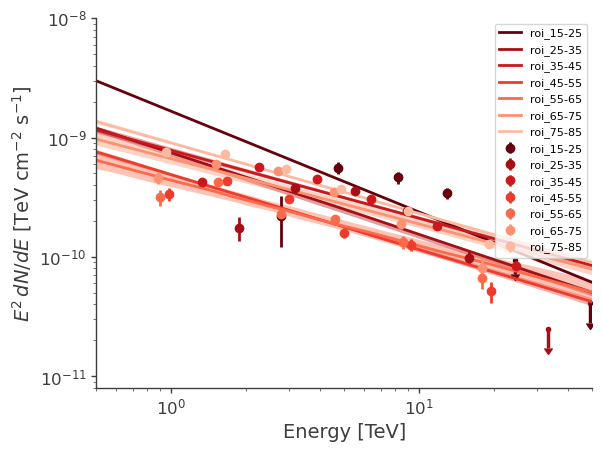

In [50]:
%matplotlib inline
import glob
gc = []
dk = []
dkf = []
de = []
di = []
die = []
den = []
dep = []
dien = []
diep = []
ss = []
ssr= []
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files): #[:7]
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    resultdict = resultsss.get_data_frame()
    gc.append(range(20,360,10)[i])
    dk.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["value"])
    de.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["error"])
    den.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["negative_error"]))
    dep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["positive_error"]))
    di.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["value"])
    die.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["error"])
    dien.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["negative_error"]))
    diep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["positive_error"]))
    try:
        dkf.append(resultsall[i][2][0])
    except:
        resultfile = np.load(f"../res/Diffuse_WCDA_case10/resultsall.npy")
        dkf = resultfile[9]
    if i < 7:
        # try:
        plot_spectra(
            resultsss,
            sources_to_use=["Diffuse"],
            include_extended=True,
            ene_min=x_Min,
            ene_max=x_Max,
            num_ene=30,
            energy_unit="TeV",
            flux_unit=f"TeV/(s cm2)", #*
            subplot=ax,
            plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i]} #
            )
        try:
            data = my.Draw_spectrum_fromfile(subfolder+"Spectrum_Diffuse.txt", label=name, color=my.red_palette[-(i+1)], subplot=ax, scale=1/dkf[i])
            my.spec2naima(f"./spec_{name}.txt", data)
        except:
            pass
        # except Exception as e:
        #     print(f"Error: {e}")
        #     continue
results=[gc,dk,de,den,dep,di,die,dien,diep, dkf]
np.save(f"../res/{region_name}/resultsall.npy",results)
from threeML.analysis_results import AnalysisResultsSet
resultsall
rrr = [it[0][0].results for it in resultsall]
analysis_set = AnalysisResultsSet(rrr)

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band10-70.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band10-70.pdf",dpi=300)

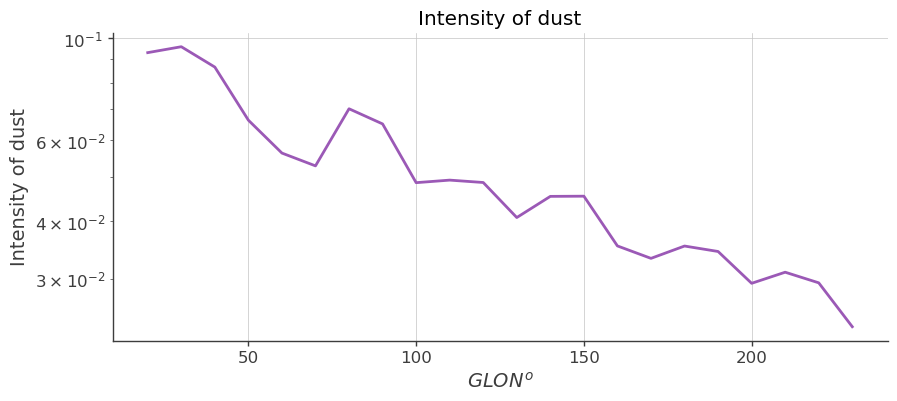

In [44]:
plt.figure(figsize=(10,4)) #
plt.plot(gc, np.array(dkf)) #np.array(den)*1e9, np.array(dep)*1e9 , fmt="o"
plt.yscale("log")
plt.title("Intensity of dust")

plt.ylabel(r"Intensity of dust")
# plt.ylim(1e-7, 1e-4)
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/dust.png",dpi=300)
plt.savefig(f"../res/{region_name}/dust.pdf",dpi=300)

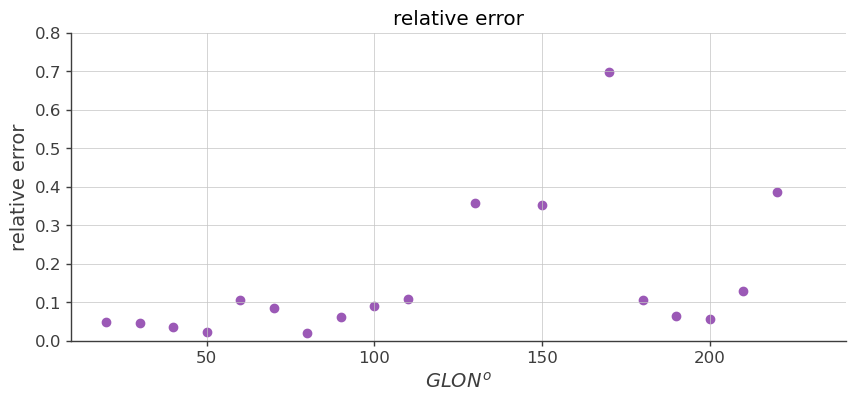

In [54]:
plt.figure(figsize=(10,4)) #
plt.scatter(gc, (np.array(de)*1e9)/(np.array(dk)*1e9), marker="o") #np.array(den)*1e9, np.array(dep)*1e9
# plt.yscale("log")
plt.title("relative error")
plt.ylim(0, 0.8)
plt.ylabel("relative error")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

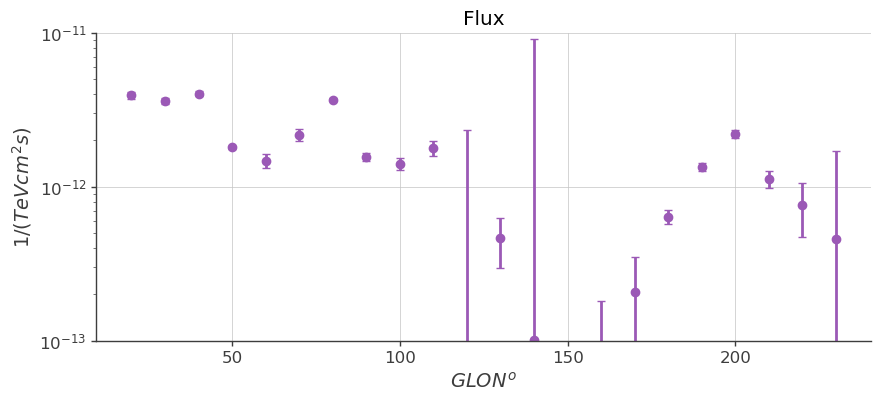

In [52]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9, [np.array(de)*1e9, np.array(de)*1e9], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-13, 1e-11)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

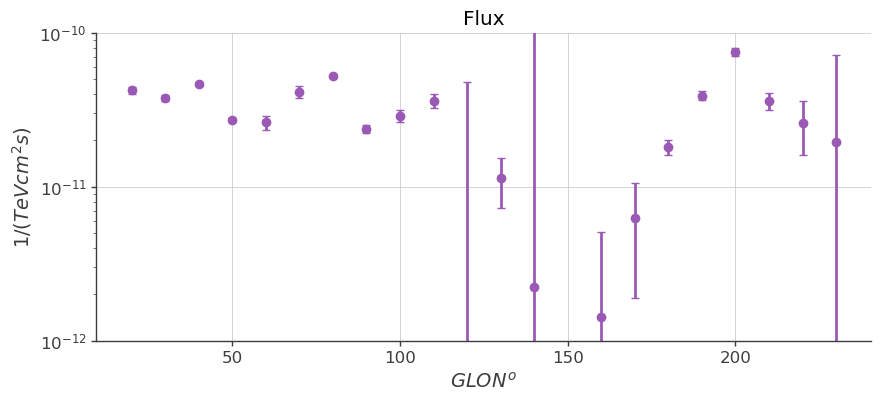

In [53]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9/np.array(dkf), [np.array(de)*1e9/np.array(dkf), np.array(de)*1e9/np.array(dkf)], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-12, 1e-10)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux_fullsky.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux_fullsky.pdf",dpi=300)

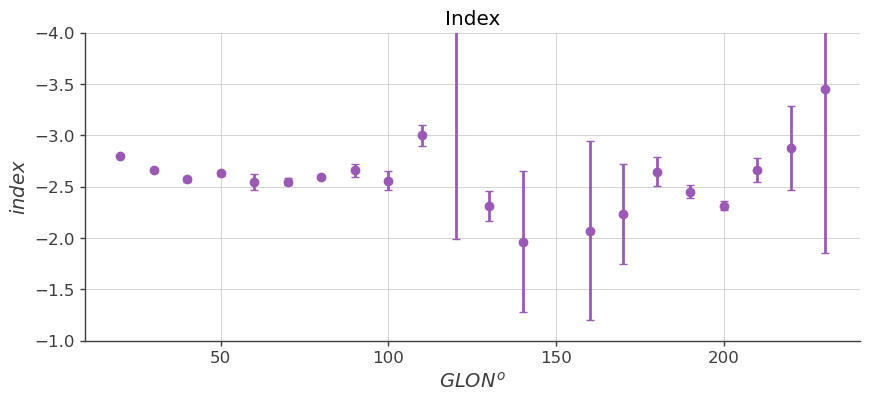

In [51]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, di, [die, die], fmt="o", capsize=3) #dien, diep
plt.ylim(-1,-4)
plt.title("Index")
plt.ylabel(r"$index$")
plt.xlabel(r"$GLON^{o}$")
plt.grid()
plt.savefig(f"../res/{region_name}/index.png",dpi=300)
plt.savefig(f"../res/{region_name}/index.pdf",dpi=300)

In [ ]:
%matplotlib inline
import glob
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files[6:14]):
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    # try:
    plot_spectra(
        resultsss,
        sources_to_use=["Diffuse"],
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit=f"TeV/(s cm2)", #*
        subplot=ax,
        plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i+6]} #
        )
    # except Exception as e:
    #     print(f"Error: {e}")
    #     continue
    

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band70-150.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band70-150.pdf",dpi=300)